## В этом проекте решим задачу бинарной классификации в компьютерном зрении. В качестве датасета у нас будет набор картинок в формате RGB. Нам надо будет научится распозновать наличие огня на них.

In [1]:
import os
import torch
from torch.autograd import Variable
from PIL import Image
from PIL import UnidentifiedImageError
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

non_fire_path = '/Users/jan/Downloads/fire_dataset/non_fire_images'
fire_path = '/Users/jan/Downloads/fire_dataset/fire_images'

#список картинок без огня
list_non_fire = []
non_fire_pictures = os.listdir(non_fire_path)
for i in non_fire_pictures:
    list_non_fire.append(non_fire_path + "/" + i)

#список картинок с огнем 
list_fire = []
fire_pictures = os.listdir(fire_path)
for i in fire_pictures:
    list_fire.append(fire_path + "/" + i)

Покажем как выглядят картинки без огня

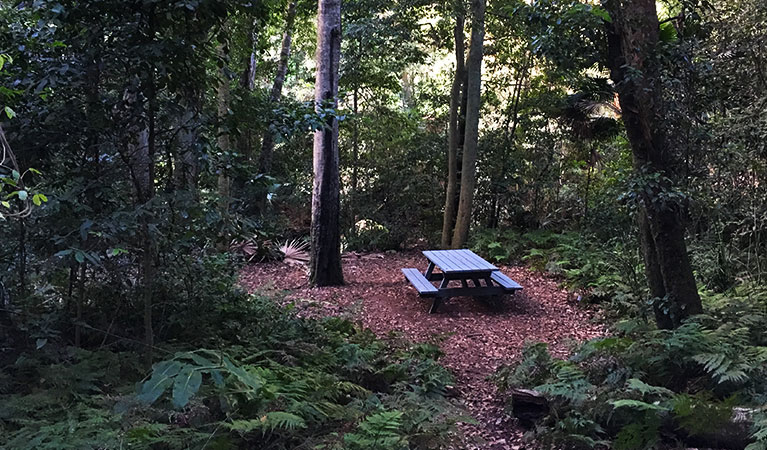

In [2]:
Image.open(list_non_fire[0])

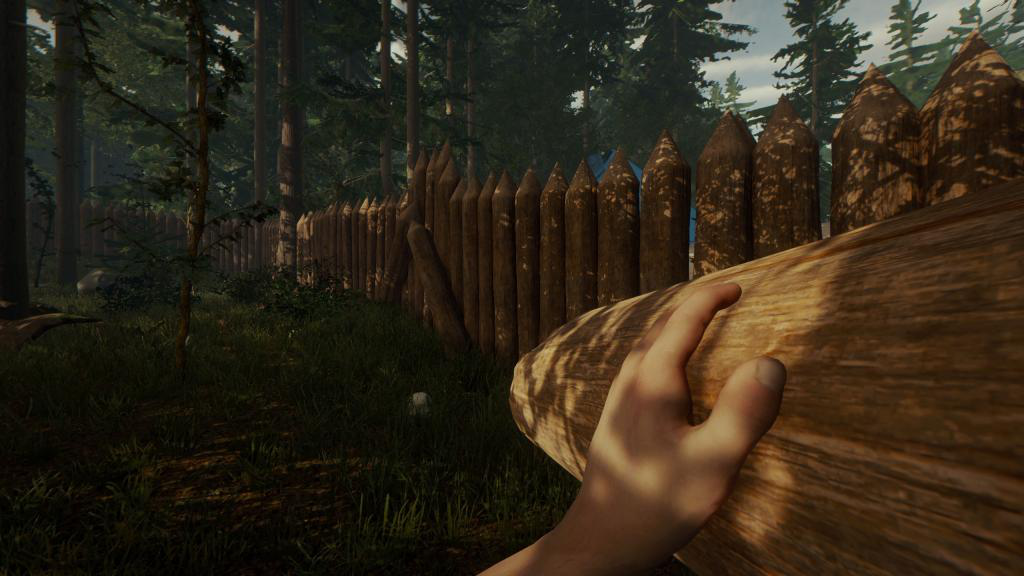

In [3]:
Image.open(list_non_fire[1])

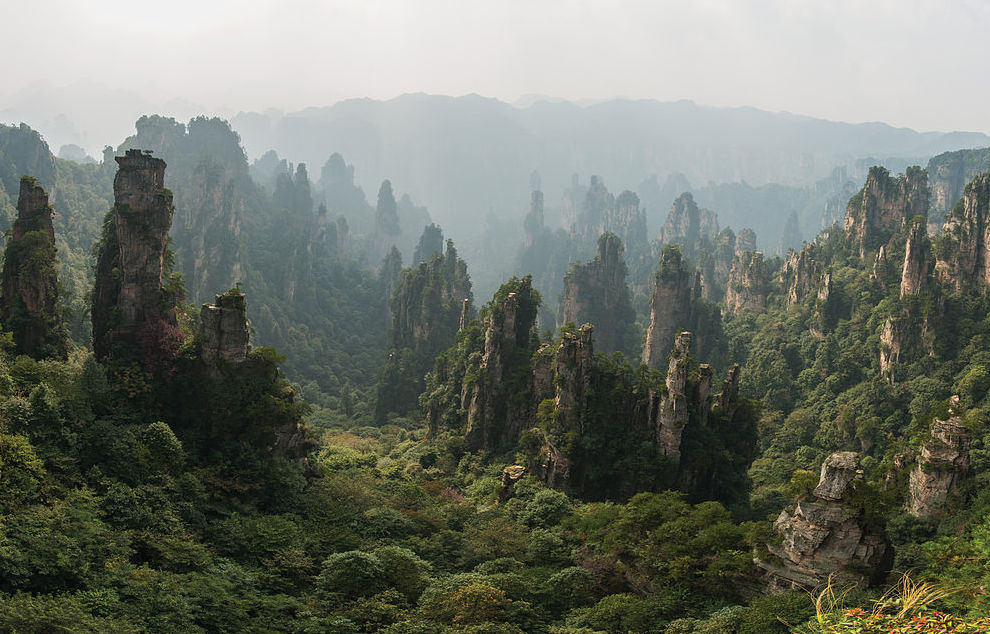

In [4]:
Image.open(list_non_fire[2])

Теперь покажем как выглядят картинки с огнем

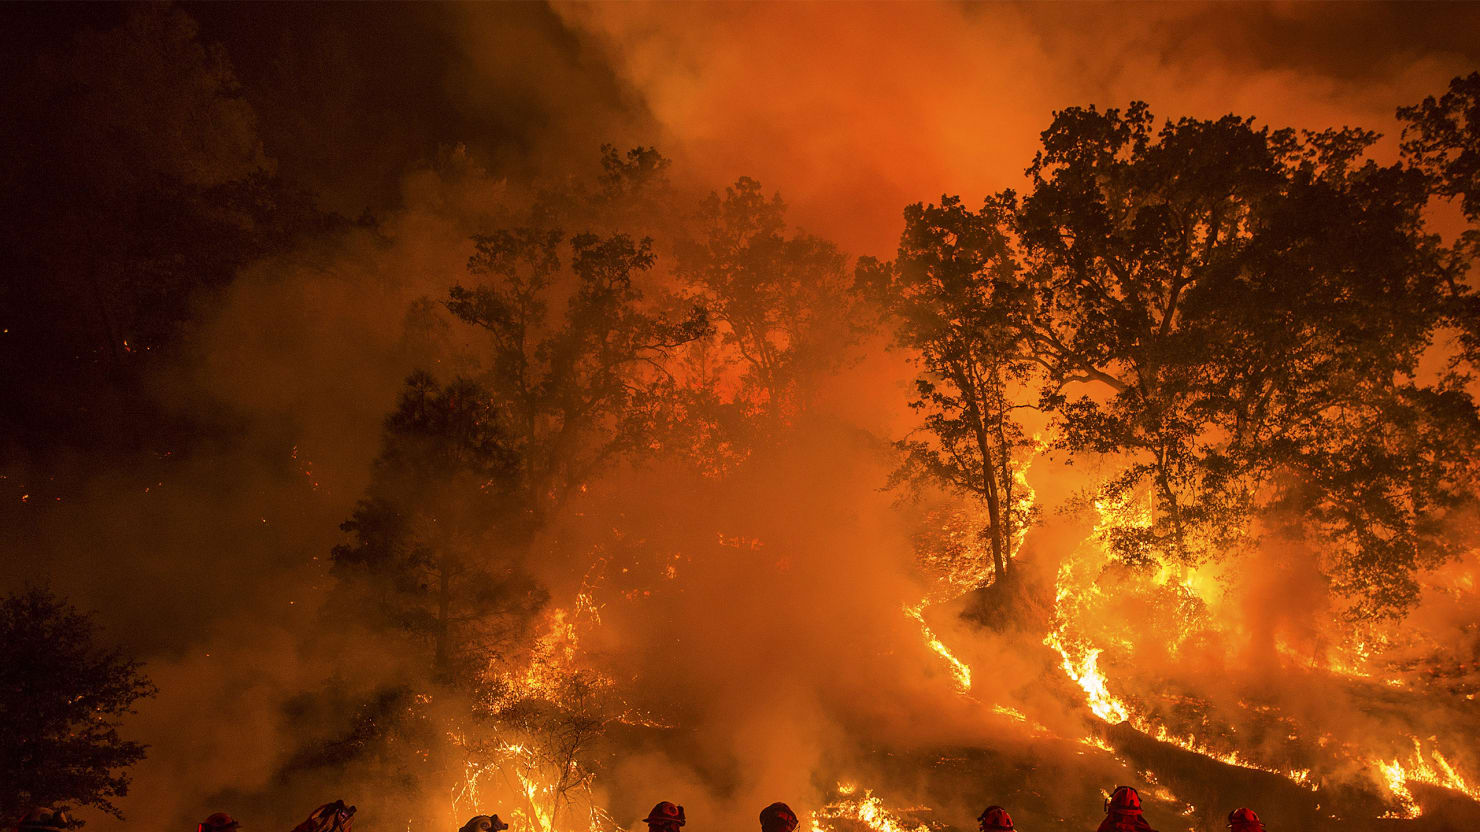

In [5]:
Image.open(list_fire[0])

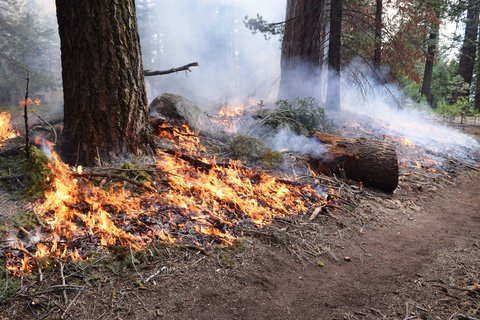

In [6]:
Image.open(list_fire[1])

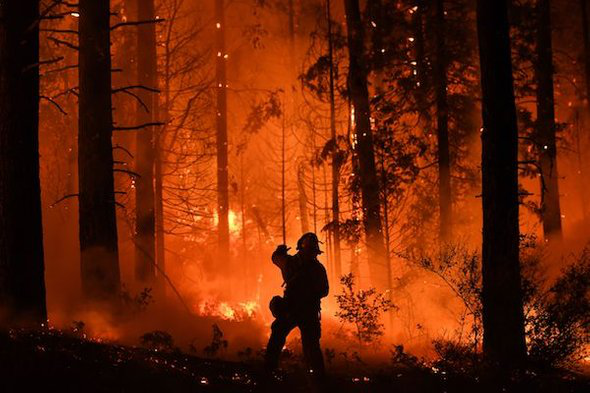

In [7]:
Image.open(list_fire[2])

In [8]:
#Эта функция преобразует Image в torch
def Transform_image_to_torch(image_input):
    arr = torch.FloatTensor(np.array(img))
    arr = arr.view(1, 3, 100, 100)
    arr = arr / 255
    arr = arr.nan_to_num(nan=0)
    return arr

In [9]:
print("length of list_non_fire =", len(list_non_fire))
print("length of list_fire =", len(list_fire))

length of list_non_fire = 244
length of list_fire = 755


Из картинок без огня сделаем массив формата torch. Будем использовать различные техники (разворот, переворот) переобразования картинок для расширени датасета, ведь 244 изображений слишком мало для обучения.

In [10]:
torch_non_fire = torch.FloatTensor(0, 3, 100, 100)

for i in list_non_fire:
    try:
        img = Image.open(i)
        img = img.convert('RGB')
        img = img.resize(size = (100, 100))
        img_r = img.transpose(Image.FLIP_LEFT_RIGHT)
        img_1 = img.rotate(45, expand=True)
        img_2 = img.rotate(-45, expand=True)
        img_3 = img.rotate(30, expand=True)
        img_4 = img.rotate(-30, expand=True)
        img_5 = img.rotate(60, expand=True)
        img_6 = img.rotate(-60, expand=True)
        img_r_1 = img_r.rotate(45, expand=True)
        img_r_2 = img_r.rotate(-45, expand=True)
        img_r_3 = img_r.rotate(30, expand=True)
        img_r_4 = img_r.rotate(-30, expand=True)
        img_r_5 = img_r.rotate(60, expand=True)
        img_r_6 = img_r.rotate(-60, expand=True)
        x = Transform_image_to_torch(img)
        x_r = Transform_image_to_torch(img_r)
        x_1 = Transform_image_to_torch(img_1)
        x_2 = Transform_image_to_torch(img_2)
        x_3 = Transform_image_to_torch(img_3)
        x_4 = Transform_image_to_torch(img_4)
        x_5 = Transform_image_to_torch(img_5)
        x_6 = Transform_image_to_torch(img_6)
        x_r_1 = Transform_image_to_torch(img_r_1)
        x_r_2 = Transform_image_to_torch(img_r_2)
        x_r_3 = Transform_image_to_torch(img_r_3)
        x_r_4 = Transform_image_to_torch(img_r_4)
        x_r_5 = Transform_image_to_torch(img_r_5)
        x_r_6 = Transform_image_to_torch(img_r_6)
        torch_non_fire = torch.cat((torch_non_fire, x, x_1, x_2, x_3, x_4, x_5, x_6, x_r, x_r_1, x_r_2, x_r_3, x_r_4, x_r_5, x_r_6), 0)
    except UnidentifiedImageError:
        continue

Из картинок с огнем сделаем массив формата torch. Будем использовать различные техники (разворот, переворот) переобразования картинок для расширени датасета, ведь 755 изображений слишком мало для обучения.

In [11]:
torch_fire = torch.FloatTensor(0, 3, 100, 100)

for i in list_fire:
    try:
        img = Image.open(i)
        img = img.convert('RGB')
        img = img.resize(size = (100, 100))
        img_1 = img.transpose(Image.FLIP_LEFT_RIGHT)
        img_2 = img.rotate(45, expand=True)
        img_3 = img.rotate(-45, expand=True)
        img_4 = img.rotate(30, expand=True)
        img_5 = img.rotate(-30, expand=True)
        x = Transform_image_to_torch(img)
        x_1 = Transform_image_to_torch(img_1)
        x_2 = Transform_image_to_torch(img_2)
        x_3 = Transform_image_to_torch(img_3)
        x_4 = Transform_image_to_torch(img_4)
        x_5 = Transform_image_to_torch(img_5)
        torch_fire = torch.cat((torch_fire, x, x_1, x_2, x_3, x_4, x_5), 0)
    except UnidentifiedImageError:
        continue

Теперь обрежем torch_fire и torch_non_fire для равномерного распределения классов.

In [12]:
torch_fire = torch_fire[:3400]
torch_non_fire = torch_non_fire[:3400]

На основе torch_fire и torch_non_fire составим тренировочную и тестовую выборку. Тренировочную выборку сделаем в 3 раза больше чем тестовую.

In [13]:
torch_X_train = torch.FloatTensor(0, 3, 100, 100)
torch_X_test = torch.FloatTensor(0, 3, 100, 100)
torch_y_train = torch.FloatTensor(0, 2)
torch_y_test = torch.FloatTensor(0, 2)
for index in range(1400):
    if (index % 4 == 0):
        torch_X_test = torch.cat((torch_X_test, (torch_non_fire[index]).view(1, 3, 100, 100)), 0)
        torch_y_test = torch.cat((torch_y_test, torch.FloatTensor([[1, 0]])), 0)
        torch_X_test = torch.cat((torch_X_test, (torch_fire[index]).view(1, 3, 100, 100)), 0)
        torch_y_test = torch.cat((torch_y_test, torch.FloatTensor([[0, 1]])), 0)
    else:
        torch_X_train = torch.cat((torch_X_train, (torch_non_fire[index]).view(1, 3, 100, 100)), 0)
        torch_y_train = torch.cat((torch_y_train, torch.FloatTensor([[1, 0]])), 0)
        torch_X_train = torch.cat((torch_X_train, (torch_fire[index]).view(1, 3, 100, 100)), 0)
        torch_y_train = torch.cat((torch_y_train, torch.FloatTensor([[0, 1]])), 0)

Построим нейросеть 

In [14]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc0 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3))
        self.fc1 = nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size = (3, 3))
        self.fc2 = nn.MaxPool2d(kernel_size = (2, 2))
        self.fc3 = nn.Flatten()
        self.fc4 = nn.Linear(529, 100)
        self.fc5 = nn.Tanh()
        self.fc6 = nn.Linear(100, 2)
        self.fc7 = nn.Softmax(dim=1)
        
        

    
    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = self.fc2(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        return x

In [15]:
model = Net()

In [16]:
print(model)

Net(
  (fc0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
  (fc2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc3): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=529, out_features=100, bias=True)
  (fc5): Tanh()
  (fc6): Linear(in_features=100, out_features=2, bias=True)
  (fc7): Softmax(dim=1)
)


In [17]:
import torchmetrics

accuracy = torchmetrics.classification.Accuracy(task='Binary')

Обучим нейросеть

In [18]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
num_epochs = 500
batch_size = 100
len_of_train = torch_X_train.size()[0]

for epoch in range(num_epochs):
    loss_sum = 0.0
    acc_train = 0.0
    p = batch_size / len_of_train
    i = 0
    count = 0
    while (i < len_of_train):
        res_proba = model(torch_X_train[i: i + batch_size])
        loss = loss_function(res_proba, torch_y_train[i: i + batch_size])
        loss_sum += p * loss
        acc_train += (torch.argmax(torch_y_train[i: i + batch_size], dim=1) == torch.argmax(res_proba, dim=1)).sum()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        i += batch_size
        count += 1
    print(loss_sum)

tensor(0.6648, grad_fn=<AddBackward0>)
tensor(0.6159, grad_fn=<AddBackward0>)
tensor(0.5850, grad_fn=<AddBackward0>)
tensor(0.5588, grad_fn=<AddBackward0>)
tensor(0.5380, grad_fn=<AddBackward0>)
tensor(0.5257, grad_fn=<AddBackward0>)
tensor(0.5126, grad_fn=<AddBackward0>)
tensor(0.5010, grad_fn=<AddBackward0>)
tensor(0.5036, grad_fn=<AddBackward0>)
tensor(0.5170, grad_fn=<AddBackward0>)
tensor(0.5284, grad_fn=<AddBackward0>)
tensor(0.4661, grad_fn=<AddBackward0>)
tensor(0.4534, grad_fn=<AddBackward0>)
tensor(0.4387, grad_fn=<AddBackward0>)
tensor(0.4256, grad_fn=<AddBackward0>)
tensor(0.4153, grad_fn=<AddBackward0>)
tensor(0.4075, grad_fn=<AddBackward0>)
tensor(0.4009, grad_fn=<AddBackward0>)
tensor(0.3956, grad_fn=<AddBackward0>)
tensor(0.3920, grad_fn=<AddBackward0>)
tensor(0.3896, grad_fn=<AddBackward0>)
tensor(0.3868, grad_fn=<AddBackward0>)
tensor(0.3846, grad_fn=<AddBackward0>)
tensor(0.3835, grad_fn=<AddBackward0>)
tensor(0.3817, grad_fn=<AddBackward0>)
tensor(0.3807, grad_fn=<A

tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<AddBackward0>)
tensor(0.3271, grad_fn=<A

tensor(0.3288, grad_fn=<AddBackward0>)
tensor(0.3638, grad_fn=<AddBackward0>)
tensor(0.3451, grad_fn=<AddBackward0>)
tensor(0.3336, grad_fn=<AddBackward0>)
tensor(0.3377, grad_fn=<AddBackward0>)
tensor(0.3676, grad_fn=<AddBackward0>)
tensor(0.3461, grad_fn=<AddBackward0>)
tensor(0.3321, grad_fn=<AddBackward0>)
tensor(0.3251, grad_fn=<AddBackward0>)
tensor(0.3330, grad_fn=<AddBackward0>)
tensor(0.3248, grad_fn=<AddBackward0>)
tensor(0.3236, grad_fn=<AddBackward0>)
tensor(0.3316, grad_fn=<AddBackward0>)
tensor(0.3217, grad_fn=<AddBackward0>)
tensor(0.3204, grad_fn=<AddBackward0>)
tensor(0.3200, grad_fn=<AddBackward0>)
tensor(0.3200, grad_fn=<AddBackward0>)
tensor(0.3200, grad_fn=<AddBackward0>)
tensor(0.3200, grad_fn=<AddBackward0>)
tensor(0.3200, grad_fn=<AddBackward0>)
tensor(0.3200, grad_fn=<AddBackward0>)
tensor(0.3200, grad_fn=<AddBackward0>)
tensor(0.3200, grad_fn=<AddBackward0>)
tensor(0.3199, grad_fn=<AddBackward0>)
tensor(0.3199, grad_fn=<AddBackward0>)
tensor(0.3199, grad_fn=<A

In [19]:
print("train acc: ", accuracy(torch.argmax(torch_y_train, dim=1), torch.argmax(model(torch_X_train), dim=1)).item())
print("test acc: ", accuracy(torch.argmax(torch_y_test, dim=1), torch.argmax(model(torch_X_test), dim=1)).item())

train acc:  0.9952380657196045
test acc:  0.9971428513526917


## Итог: Мы обучили модель распозновать картинки !!!
## Точность на тестовой выборке = 99.71 %